In [14]:
import numpy as np
# import necessary libraries
import pandas as pd

In [15]:
data = pd.read_csv('df_merged_weekly_all.csv', index_col=0)
data['date'] = pd.to_datetime(data['date'])
data.reset_index(inplace=True)
data

,level_0,index,week,date,cases,temperature,pressure,humidity,precipitation
0,0,0,2016-1,2016-01-10,19.0,303.437143,1012.285714,71.428571,1.02
1,1,1,2016-2,2016-01-17,23.0,303.908571,1012.857143,65.571429,0.00
2,2,2,2016-3,2016-01-24,31.0,302.251429,1014.428571,76.857143,32.85
3,3,3,2016-4,2016-01-31,26.0,302.778571,1011.142857,75.142857,17.05
4,4,4,2016-5,2016-02-07,10.0,303.285714,1012.428571,70.571429,3.70
...,...,...,...,...,...,...,...,...,...
393,393,135,2024-32,2024-08-05,226.0,302.210000,1009.000000,75.000000,8.78
394,394,136,2024-33,2024-08-12,205.0,303.050000,1007.000000,70.000000,4.91
395,395,137,2024-34,2024-08-19,209.0,303.620000,1009.000000,67.000000,11.63
396,396,138,2024-35,2024-08-26,162.0,302.490000,1008.000000,73.000000,10.55


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   level_0        398 non-null    int64         
 1   index          398 non-null    int64         
 2   week           398 non-null    object        
 3   date           398 non-null    datetime64[ns]
 4   cases          398 non-null    float64       
 5   temperature    398 non-null    float64       
 6   pressure       398 non-null    float64       
 7   humidity       398 non-null    float64       
 8   precipitation  398 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 28.1+ KB


In [17]:
data['month'] = data['date'].dt.month.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
data

,level_0,index,week,date,cases,temperature,pressure,humidity,precipitation,month
0,0,0,2016-1,2016-01-10,19.0,303.437143,1012.285714,71.428571,1.02,Jan
1,1,1,2016-2,2016-01-17,23.0,303.908571,1012.857143,65.571429,0.00,Jan
2,2,2,2016-3,2016-01-24,31.0,302.251429,1014.428571,76.857143,32.85,Jan
3,3,3,2016-4,2016-01-31,26.0,302.778571,1011.142857,75.142857,17.05,Jan
4,4,4,2016-5,2016-02-07,10.0,303.285714,1012.428571,70.571429,3.70,Feb
...,...,...,...,...,...,...,...,...,...,...
393,393,135,2024-32,2024-08-05,226.0,302.210000,1009.000000,75.000000,8.78,Aug
394,394,136,2024-33,2024-08-12,205.0,303.050000,1007.000000,70.000000,4.91,Aug
395,395,137,2024-34,2024-08-19,209.0,303.620000,1009.000000,67.000000,11.63,Aug
396,396,138,2024-35,2024-08-26,162.0,302.490000,1008.000000,73.000000,10.55,Aug


# Columns
| column        | description                             | type     |
|---------------|-----------------------------------------|----------|
| week          | week corresponding to the specific year | datetime | 
| dt            | specific date                           | datetime |
| Cases         | Dengue Cases                            | integer  |
| temp          | Average temperature in the given week   | numeric  |
| feels_like    | Average feels_life in the given week    | numeric  |
| pressure      | Average pressure in the given week      | numeric  |
| humidity      | Average humidity in the given week      | numeric  |
| precipitation | Total precipitation in the given week   | numeric  |

## Training data
Data used to be trained range from 2022 to 2023

## Testing data
Data used to be tested is 2024 (also used for training)

# Exploratory Data Analysis


<Axes: >

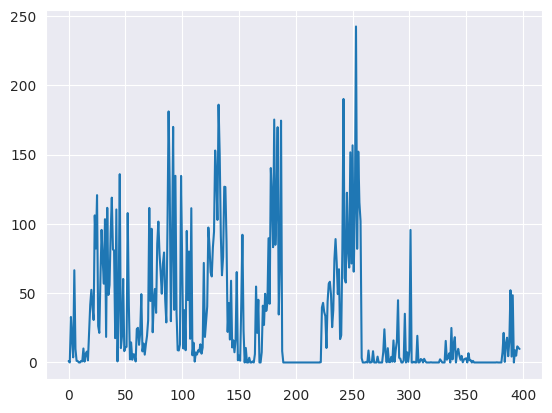

In [11]:
data.precipitation.plot()

In [36]:
# Training the rf model
# defining a function for general looping of n-week aheads
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


def train_rf(data_, features, target, date_col, n_ahead):
    # Select relevant columns
    rel_col = features + [target] + [date_col] 
    data = data_[rel_col]
    
    
    # Define lags
    env_lags = [1,2,3,4]   #2-week lag for environment features
    cases_lag = range(n_ahead, 12)  # 1 to 11 week lags for target variable
    
    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    
    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)
    # Remove any rows with missing values due to lagging
    data = data.dropna()
    #data = pd.get_dummies(data, columns=['month'])
    #for lag in cases_lag:
        # scaling the cases lag to Standard Scaling
    #    data[f'{target}_lag_{lag}'] = StandardScaler().fit_transform(np.array(data[f'{target}_lag_{lag}']).reshape(-1,1))
    #    print(data[f'{target}_lag_{lag}'].head())
    for lag in env_lags:
        for feature in features:
            data[f'{feature}_lag_{lag}'] = StandardScaler().fit_transform(np.array(data[f'{feature}_lag_{lag}']).reshape(-1,1))
    print(data['cases'].head())
    train = data[data[date_col].dt.year < 2023]
    test = data[data[date_col].dt.year >= 2023]
    train_x = train.drop(columns=[date_col,target])
    train_y = train[target]
    test_x = test.drop(columns=[date_col,target])
    test_y = test[target]
    # initialize rf model
    rf = RandomForestRegressor()
    rf.fit(train_x, train_y)
    y_pred = rf.predict(test_x)
    # Initialize list for storing predictions
    
    MAE = mean_absolute_error(test_y, y_pred)
    return y_pred, MAE, rf, data.columns

In [37]:
# Perform Initial Testing
target="cases"
features=["temperature","humidity","precipitation"]
date = 'date'
prediction_1_week, MAE_1_week, rf_model_1_week, column_names = train_rf(data, features, target, date, 1)
prediction_4_week, MAE_4_week, rf_model_4_week, column_names_2 = train_rf(data, features, target, date, 4)
prediction_12_week,MAE_12_week, rf_model_12_week, column_names_3 = train_rf(data, features, target, date, 12)

11     8.0
12     5.0
13    13.0
14     7.0
15     8.0
Name: cases, dtype: float64
11     8.0
12     5.0
13    13.0
14     7.0
15     8.0
Name: cases, dtype: float64
4    10.0
5    11.0
6    10.0
7    18.0
8    12.0
Name: cases, dtype: float64


In [38]:
print(f'The Mean Absolute Error of the 1-Week Ahead Model is {MAE_1_week}')
print(f'The Mean Absolute Error of the 4-Week Ahead Model is {MAE_4_week}')
print(f'The Mean Absolute Error of the 12-Week Ahead Model is {MAE_12_week}')

The Mean Absolute Error of the 1-Week Ahead Model is 9.293977272727274
The Mean Absolute Error of the 4-Week Ahead Model is 17.600340909090907
The Mean Absolute Error of the 12-Week Ahead Model is 21.358295454545456


In [39]:
len(rf_model_1_week.feature_importances_)

26

In [40]:
feature_names = list(column_names)
feature_names.remove(target)
feature_names.remove('date')
feature_names_2 = list(column_names_2)
feature_names_3 = list(column_names_3)
feature_names_2.remove(target)
feature_names_2.remove('date')
feature_names_3.remove(target)
feature_names_3.remove('date')
feature_imp_1_week = pd.DataFrame({'Features':  feature_names, 'Values': list(rf_model_1_week.feature_importances_)})
feature_imp_4_week = pd.DataFrame({'Features': feature_names_2, 'Values': list(rf_model_4_week.feature_importances_)})
feature_imp_12_week = pd.DataFrame({'Features': feature_names_3, 'Values': list(rf_model_12_week.feature_importances_)})

# Visualization

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
first_2024 = int((data['date'].dt.year==2023).idxmax())
last_2024 = int(data.loc[data['date'].dt.year == 2024].index[-1])
date = data.loc[first_2024:last_2024]['date']

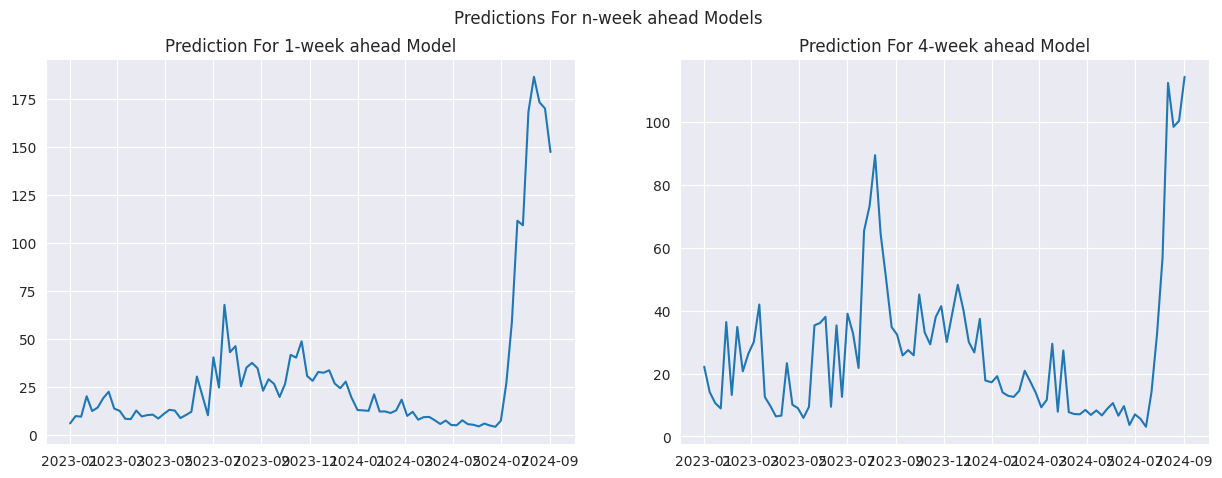

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(date,prediction_1_week)
ax[0].set_title('Prediction For 1-week ahead Model')
ax[1].plot(date,prediction_4_week)
ax[1].set_title('Prediction For 4-week ahead Model')
plt.suptitle('Predictions For n-week ahead Models')
plt.show()

Text(0.5, 1.0, 'Actual Cases')

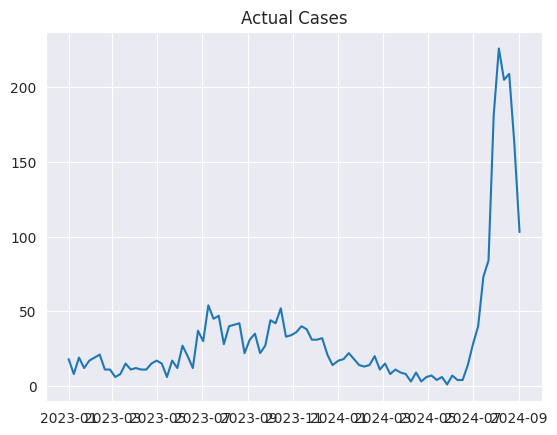

In [43]:
actual = data[data['date'].dt.year >= 2023]
plt.plot(actual['date'], actual['cases'])
plt.plot()
plt.title('Actual Cases')

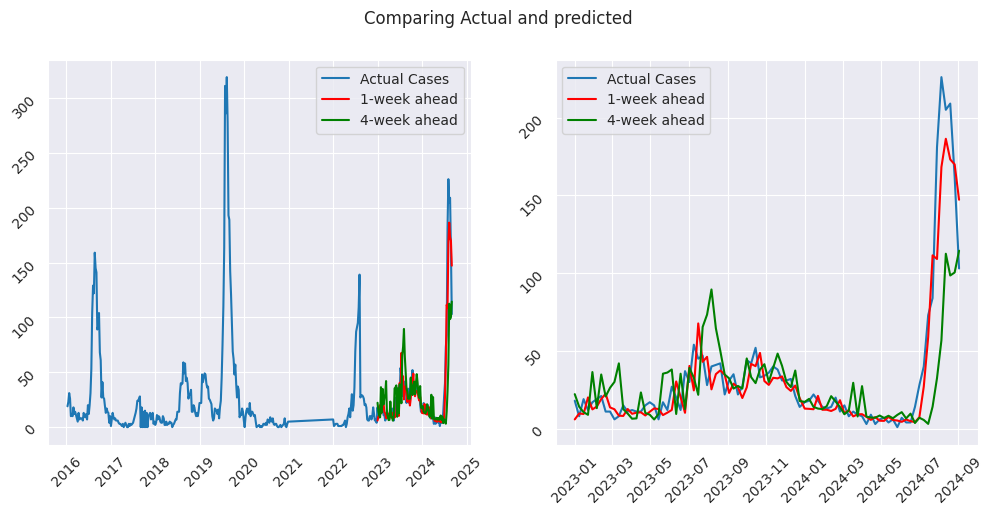

In [44]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(data['date'], data['cases'], label = 'Actual Cases')
ax[0].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[0].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[0].tick_params(labelrotation=45)
ax[0].legend()
ax[1].plot(actual['date'], actual['cases'], label = 'Actual Cases')
ax[1].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[1].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[1].tick_params(labelrotation=45)
ax[1].legend()
plt.suptitle('Comparing Actual and predicted')
plt.show()

Text(0.5, 1.0, 'Feature Importance for the 1-Week Ahead RF model')

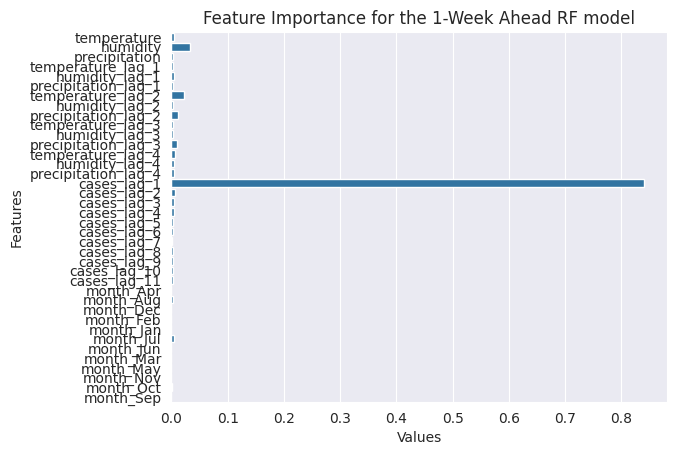

In [31]:
sns.barplot(data = feature_imp_1_week, y = 'Features', x = 'Values', orient='horizontal')
plt.title('Feature Importance for the 1-Week Ahead RF model')

Text(0.5, 1.0, 'Feature Importance for the 4-Week Ahead RF model')

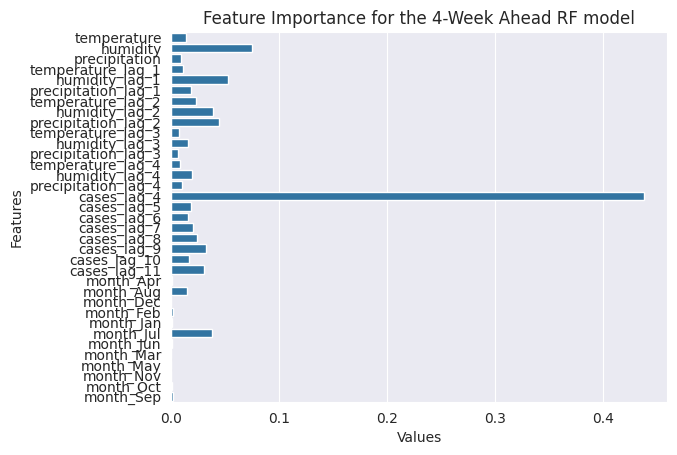

In [32]:
sns.barplot(data = feature_imp_4_week, y = 'Features', x = 'Values', orient='horizontal')
plt.title('Feature Importance for the 4-Week Ahead RF model')

In [ ]:
%%sql


Text(0.5, 1.0, 'Feature Importance for the 12-Week Ahead RF model')

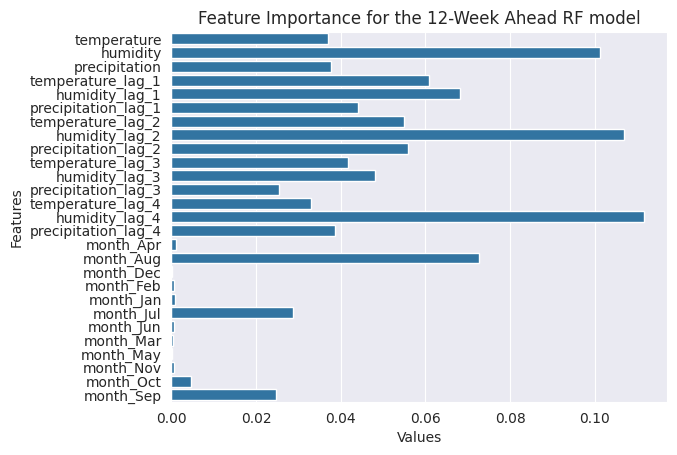

In [33]:
sns.barplot(data = feature_imp_12_week, y = 'Features', x = 'Values', orient='horizontal')
plt.title('Feature Importance for the 12-Week Ahead RF model')

In [68]:
feature_imp_1_week

,Features,Values
0,temperature,0.002054
1,humidity,0.010014
2,precipitation,0.002532
3,temperature_lag_1,0.002775
4,humidity_lag_1,0.002612
5,precipitation_lag_1,0.003531
6,temperature_lag_2,0.013643
7,humidity_lag_2,0.003443
8,precipitation_lag_2,0.007912
9,temperature_lag_3,0.001976
